In [1]:
# import necessary modules
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Deterministic Approximation - Population Zone Plot

In [2]:
def R(y,t):
    
    # set variable space
    F,Tdw,C,D,S = y
    
    # mass balance
    Tup = total - F - Tdw - C
    
    # reaction equations
    dFdt = fp*Tup - dp*(1-fp)*F - (1-dp)*F
#     dTupdt = -Tup + (1-pp)*(C+Tdw) + pp*( (Tdw+C)/(D+Tdw+C) )*(C+Tdw)
    dTdwdt = dp*(1-fp)*F + (1-fp)*Tup - Tdw
    dCdt = (1-dp)*F - (1-pp)*C + pp*( D/(D+Tdw+C) )*Tdw - pp*( (Tdw+C)/(D+Tdw+C) )*C
    
    dDdt = dp*F - pp*( D/(D+Tdw+C) )*(C+Tdw)
    
    dSdt = (1-dp)*F + pp*( D/(D+Tdw+C) )*(C+Tdw)
    
    return dFdt, dTdwdt, dCdt, dDdt, dSdt

In [3]:
total = 25
fp = .95
probs = [
    (.70,.80),
    (.80,.80),
    (.90,.80)
]

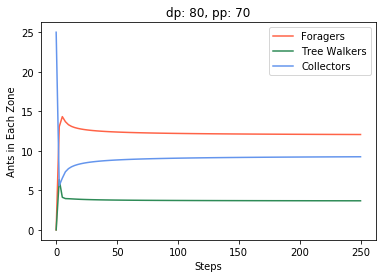

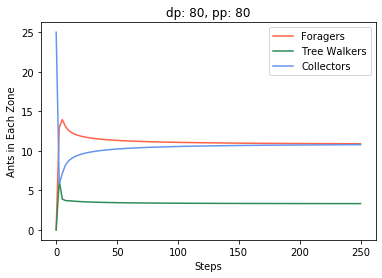

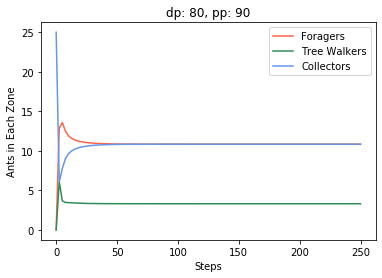

In [4]:
t = np.linspace(0,250,100)

for pp,dp in probs:
    y = odeint(R,[0,0,total,0,0],t)

    F = y[:,0]
    Tdw = y[:,1]
    C = y[:,2]
    D = y[:,3]
    S = y[:,4]
    Tup = total - F - Tdw - C
    
#     print(f'score: {int(S[-1])}')
    
    plt.plot(t,F,label='Foragers',color='tomato')
    plt.plot(t,Tup+Tdw,label='Tree Walkers',color='seagreen')
    plt.plot(t,C,label='Collectors',color='cornflowerblue')
    
    plt.legend(loc='upper right')
    plt.title(f'dp: {int(dp*100)}, pp: {int(pp*100)}')
    plt.ylabel('Ants in Each Zone')
    plt.xlabel('Steps')
    plt.show()

# Deterministic Approximation - Landscape Plot

In [5]:
import pandas as pd
import scipy
import seaborn as sns
sns.set_style("whitegrid")

In [6]:
total = 25
fp = .95

t = np.linspace(0,250,100)

# set iteration parameters
spacing = 5  # test every X trait values
run_num = 10 # simulation runs per trait combination
step_num = 1000 # model steps per run

landscape_data = []
for dp in np.arange(0,1.01,.05):
    for pp in np.arange(0,1.01,.05):
        
        y = odeint(R,[0,0,total,0,0],t)

        F = y[:,0]
        Tdw = y[:,1]
        C = y[:,2]
        D = y[:,3]
        S = y[:,4]
        Tup = total - F - Tdw - C
        
        landscape_data.append((dp, pp, F[-1], Tup[-1]+Tdw[-1], C[-1]))

In [7]:
def pull_data_F(master_data):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, F, T, C in landscape_data:
        dps.append(dp*100)
        pps.append(pp*100)
        z_variable.append(F)
    return dps,pps,z_variable

def pull_data_T(master_data):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, F, T, C in landscape_data:
        dps.append(dp*100)
        pps.append(pp*100)
        z_variable.append(T)
    return dps,pps,z_variable

def pull_data_C(master_data):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, F, T, C in landscape_data:
        dps.append(dp*100)
        pps.append(pp*100)
        z_variable.append(C)
    return dps,pps,z_variable

In [8]:
def interpolate(data_input, interpolation_function='linear'):
    """
    Transforms raw iterated simulation data into condensed data structure
    Maps interpolated scores onto dense mesh grid of traits (dp x pp)
    
    Interpolation functions :
    
    'linear': r
    'cubic': r**3
    'quintic': r**5
    'thin_plate': r**2 * log(r)
    'gaussian': exp(-(r/self.epsilon)**2)
    'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
    'multiquadric': sqrt((r/self.epsilon)**2 + 1)
    """
    # unpack data
    dps, pps, z_variable = data_input
    
    # convert into dictionary
    data_dict = {'drop_prob':dps, 
            'pickup_prob':pps, 
            'z_variable':z_variable}
    
    # output as 2D data structure via pandas DataFrame  
    df = pd.DataFrame(data_dict) 
    
    # align the repeated runs with same (dp x pp) + condense by averaging the scores
    means = df.groupby(['drop_prob', 'pickup_prob'], as_index=False)['z_variable'].mean()
    
    # set each data column to different axes
    x = means['pickup_prob']
    y = means['drop_prob']
    z = means['z_variable']
    
    # create mesh grid to map interpolation onto
    xi, yi = np.linspace(x.min(), x.max(), 101), np.linspace(y.min(), y.max(), 101)
    xi, yi = np.meshgrid(xi, yi)
    
    # interpolate the input dp x pp x score data
    rbf = scipy.interpolate.Rbf(x, y, z, function=interpolation_function)
    
    # map interpolation onto the mesh grid, creates a new estimated score for each grid position
    zi = rbf(xi, yi)
    
    return xi, yi, zi

In [9]:
def gradient_arrow_heatmap(interpolated_data, max_min, title, z_min=0, z_max=0,
                   normalize=True, vanishing_arrows=True, arrow_size=.5):
    """
    Calculates a mesh of arrows which shows direction and/or strength of gradient 
        along interpolated trait-score landscape
    Plots heatmap along with mesh with key design parameters:
    - normalize:
        - TRUE: arrows show direction only, gradient strength (arrow length) is equalized
    - vanishing_arrows:
        - TRUE: arrows with low gradient strength are displayed as dots
        - FALSE: arrows with low gradient strength are displayed as arrow heads
    """
    # unpacks interpolated output of interpolate()
    xi,yi,zi = interpolated_data
    
    # origins of arrows set to every 5 trait values in the middle of the grid (excluding 0, 100)
    a_min, a_max, a_stepsize = 5, 96, 5
    
    # discretizes interpolated data according to arrow origins
    xia = xi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    yia = yi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    zia = zi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    
    # finds gradient of the interpolated score arrow matrix
    yig, xig = np.gradient(zia)
    
    # plot background heatmap from interpolated data
    plot_heatmap(interpolated_data, max_min, title, z_min, z_max)
    
    # decision hierarchy which decides plot design
    # normalizing disregards gradient strength >> arrows are same length + only show direction
    # vanishing_arrows uses quiver() >> minimum length arrows plot as dots
    # non-vanishing_arrows uses arrow() + vectorize() >> minimum length arrows plot as arrow heads
    
    if normalize == True:
        dx = xig / np.sqrt(xig**2 + yig**2)
        dy = yig / np.sqrt(xig**2 + yig**2)
        
        plt.quiver(xia, yia, dx, dy, headwidth=5, headlength=5)
            
    else: # normalize: False
        dx, dy = xig, yig
        
        if vanishing_arrows == True:
            plt.quiver(xia, yia, dx, dy, headwidth=5, headlength=5)
        else: # vanishing_arrows: False
            vectorized_arrow_drawing = np.vectorize(func_to_vectorize)
            vectorized_arrow_drawing(xia, yia, dx, dy, 0.01 * arrow_size)

    plt.show()
    
def plot_heatmap(interpolated_data, max_min, title, z_min, z_max, cmap=plt.cm.gist_rainbow):
    """
    Plots heatmap of interpolated trait-score data
    Called within gradient_arrow_heatmap()
    """
    # unpacks interpolated output of interpolate()
    xi,yi,zi = interpolated_data
    
    # if no max score is defined, uses the maximum interpolated value
    if z_max == 0:
        z_max = np.max(zi)
    
    # sets up figure
    _, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title)
    ax.set_xlabel('Pickup probability', fontsize=12)
    ax.set_ylabel('Drop probability', fontsize=12)
    
    # plots heatmap according to color scheme, bounded in the x/y/z directions
    hm = ax.imshow(zi, interpolation='none', cmap=cmap,
                extent=[xi.min(), xi.max(), yi.min(), yi.max()], origin=[0,0],
                vmin=z_min, vmax=z_max) 
    
    # adds color bar to the right side of heatmap
    cbar = plt.colorbar(hm)
    
    if max_min != 0:
        # pull max + min data
        dp_max, pp_max, z_max, dp_min, pp_min, z_min = max_min

        plt.plot(pp_max,dp_max,'ro')
        plt.plot(pp_min,dp_min,'bo')
        
def func_to_vectorize(x, y, dx, dy, scaling):
    """
    Used for plotting gradient arrows in conjunction with vectorize()
    Called within gradient_arrow_heatmap()
    """
    plt.arrow(x, y, dx*scaling, dy*scaling, fc="k", ec="k", head_width=1.5, head_length=1)

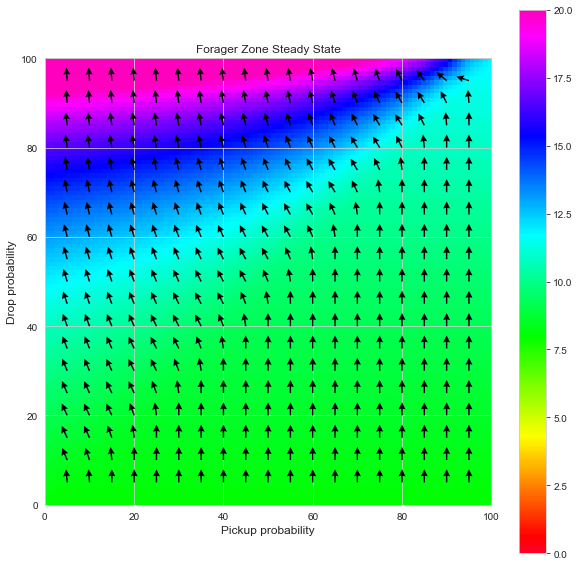

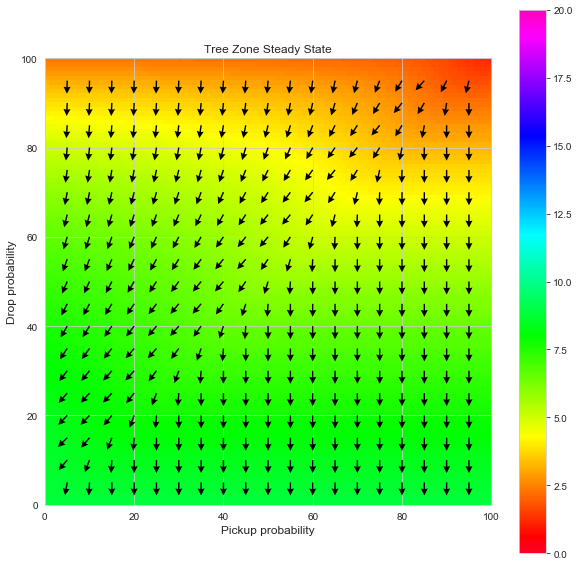

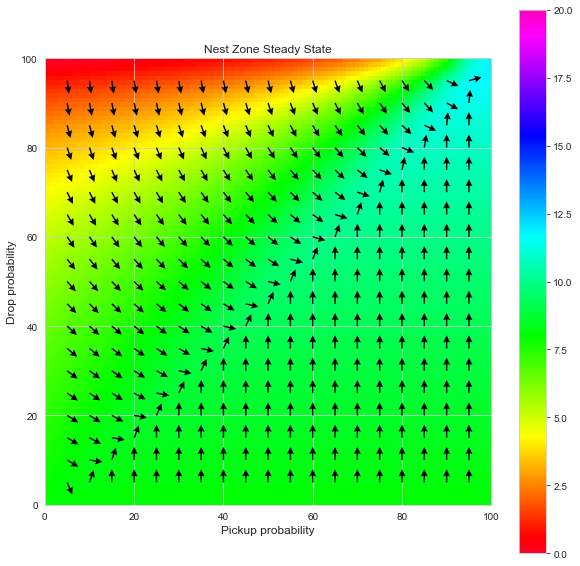

In [10]:
plot_max = 15

data = pull_data_F(landscape_data)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, 
    title='Forager Zone Steady State',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_T(landscape_data)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, 
    title='Tree Zone Steady State',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_C(landscape_data)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min=0, 
    title='Nest Zone Steady State',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)